In [41]:
# Import all functions needed in the notebook
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from reactions import run_model_sm1 as run_model
from corrosion_calc import corrosion_rate_H2SO4, corrosion_rate_HNO3, surface_area

In [42]:
# This is a helper function we use to apply over our data frame. Should not be edited
def wrap_corrosion_calc(argument):
    kwargs = argument.to_dict()
    area = surface_area(kwargs["inner_diameter"],kwargs["drop_out_length"])
    argument["H2SO4_corrosion"] = corrosion_rate_H2SO4(area, kwargs["flowrate"],kwargs["H2SO4"])
    argument["HNO3_corrosion"] = corrosion_rate_HNO3(area, kwargs["flowrate"],kwargs["HNO3"])
    argument["corrosion_rate"] = argument["H2SO4_corrosion"] + argument["HNO3_corrosion"]
    return argument


In [43]:
# This is a helper function we use to apply over our data frame. Should not be edited
def wrap_runmodel(argument):
    concentrations = argument.to_dict()
    concentrations["NO"] = 0
    concentrations["H2SO4"] = 0
    concentrations["HNO3"] = 0
    run_model(concentrations)
    argument["H2SO4"] = concentrations["H2SO4"]
    argument["HNO3"] = concentrations["HNO3"]

    return argument

In [44]:
# Create the data needed for plotting

# The constituents below are the ones that we want to vary.
constituents = ["O2", "NO2"]

# These are the values the will be used for the constituents. As is it will be (0, 1, 2, 3...20)/2 = (0, 0.5, 1...10)
values = [i / 2 for i in range(21)]

result = pd.DataFrame(
    itertools.product(values, repeat=len(constituents)), columns=constituents
)
# The remaining parameters are set to 0. It is possible to swap parameters to be varied and to be constant
# For instance by replacing e.g O2 with H2S in the list of constituents. The value of O2 must then be defaulted here.
result["H2O"] = 30
result["SO2"] = 10
result["H2S"] = 0
result["inner_diameter"] = 30
result["drop_out_length"] = 1000
result["flowrate"] = 20
result = result.apply(wrap_runmodel, axis=1)
result = result.apply(wrap_corrosion_calc, axis=1)

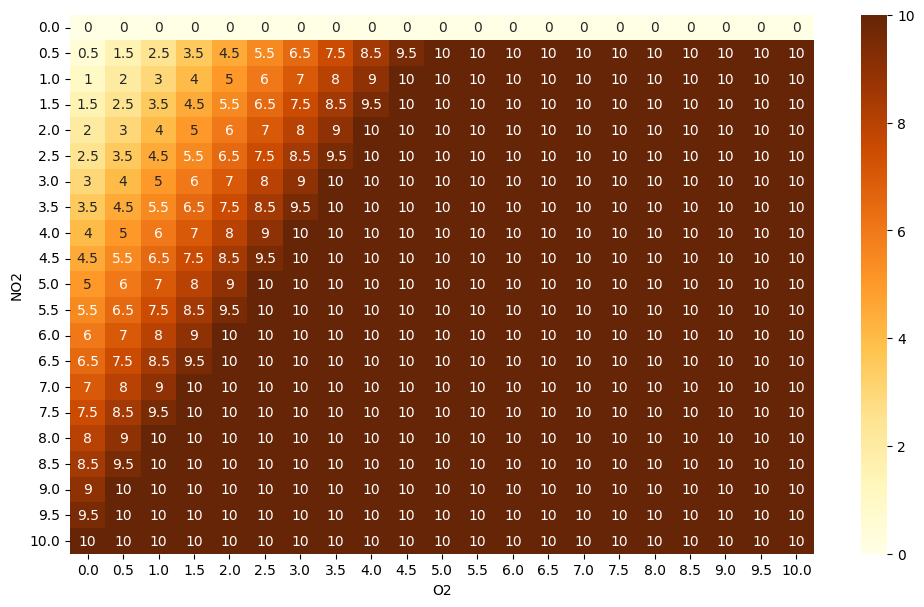

In [45]:
# Specify size for the final figure here
fig, ax = plt.subplots(figsize=(12,7))

# The index parameter is used as the "vertical" axis, while the column parameter is the "horizontal" axis
plot_df = result.pivot_table(index="NO2", columns="O2", values="H2SO4")
sns.heatmap(plot_df, annot=True, ax=ax, cmap="YlOrBr")

# Export the values to a csv table (note this will overwrite each time the codeblock is run)
plot_df.to_csv("H2SO4_table.csv")


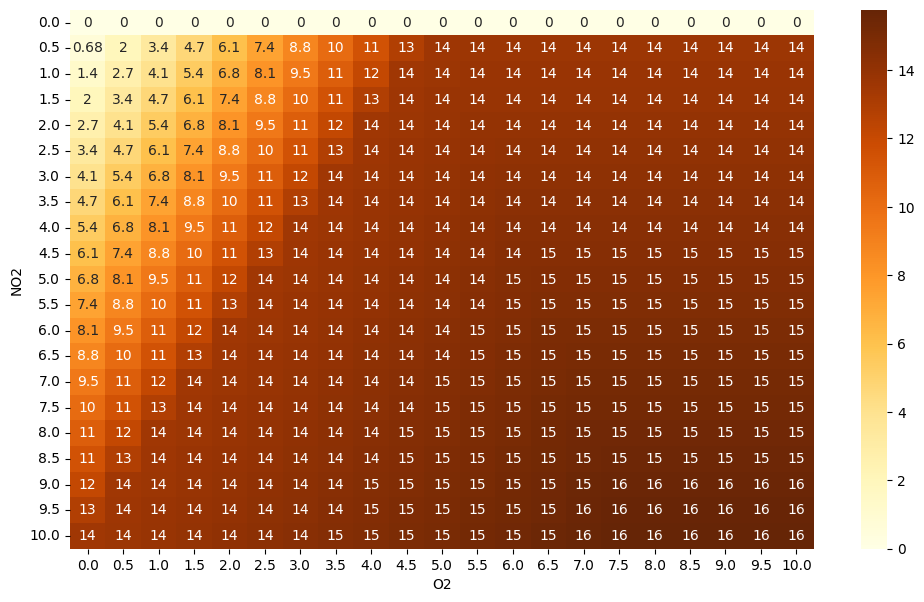

In [46]:
# Specify size for the final figure here
fig, ax = plt.subplots(figsize=(12,7))

# The index parameter is used as the "vertical" axis, while the column parameter is the "horizontal" axis
plot_df = result.pivot_table(index="NO2", columns="O2", values="corrosion_rate")
sns.heatmap(plot_df, annot=True, ax=ax, cmap="YlOrBr")

# Export the values to a csv table (note this will overwrite each time the codeblock is run)
plot_df.to_csv("corrosion_table.csv")
